In [1]:
sys.path.append('../')
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
pd.set_option('max_columns', None)
import os

In [2]:
%%capture
from tqdm import tqdm_notebook

In [3]:
df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [4]:
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME']) # not null dataframe (model training)

In [5]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

In [6]:

litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.3, .7], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [7]:
print(train.shape, litho_data.shape)

(388833, 9) (1294715, 9)


In [8]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK', 'Set'])

Y = train['LITHOLOGY_GEOLINK']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [9]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (248852, 7) (248852,)
### Validation Dataset: ###  (62214, 7) (62214,)
### Test Dataset: ###  (77767, 7) (77767,)


In [10]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [11]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

In [12]:
clf = TabNetClassifier(               optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cuda


In [13]:
max_epochs = 1000

clf.fit(
    X_train=x_train.values, y_train=y_train,
    eval_set=[(x_train.values, y_train), (x_val.values, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs , patience=100,
    batch_size=2048,
    num_workers=0,
    weights=1,
    drop_last=False
)

44 | valid_balanced_accuracy: 0.65736 |  0:48:54s
epoch 155| loss: 0.86876 | train_balanced_accuracy: 0.7256  | valid_balanced_accuracy: 0.65817 |  0:49:13s
epoch 156| loss: 0.86797 | train_balanced_accuracy: 0.72752 | valid_balanced_accuracy: 0.66128 |  0:49:33s
epoch 157| loss: 0.86495 | train_balanced_accuracy: 0.72449 | valid_balanced_accuracy: 0.65846 |  0:49:52s
epoch 158| loss: 0.8678  | train_balanced_accuracy: 0.7249  | valid_balanced_accuracy: 0.66209 |  0:50:11s
epoch 159| loss: 0.87021 | train_balanced_accuracy: 0.7298  | valid_balanced_accuracy: 0.66176 |  0:50:31s
epoch 160| loss: 0.86731 | train_balanced_accuracy: 0.72682 | valid_balanced_accuracy: 0.6591  |  0:50:50s
epoch 161| loss: 0.86115 | train_balanced_accuracy: 0.72579 | valid_balanced_accuracy: 0.66117 |  0:51:09s
epoch 162| loss: 0.87048 | train_balanced_accuracy: 0.72492 | valid_balanced_accuracy: 0.65631 |  0:51:29s
epoch 163| loss: 0.86428 | train_balanced_accuracy: 0.72726 | valid_balanced_accuracy: 0.66108

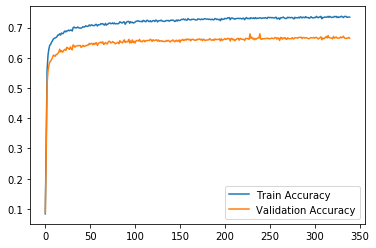

In [14]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

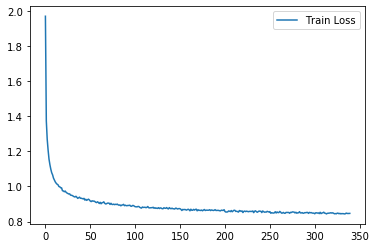

In [15]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()


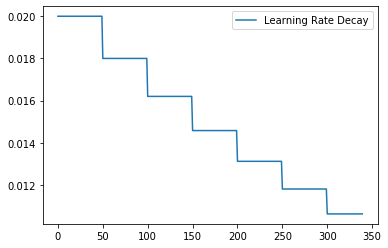

In [16]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()
